# Assignment 1: Sampling and Reproducibility

The code at the end of this file explores contact tracing data about an outbreak of the flu, and demonstrates the dangers of incomplete and non-random samples. This assignment is modified from [Contact tracing can give a biased sample of COVID-19 cases](https://andrewwhitby.com/2020/11/24/contact-tracing-biased/) by Andrew Whitby.

Examine the code below. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved. 


Updates added on Oct 18, 2025 based on comments from Learning Support: 
*For primary tracing is random only among the infected (each infected has a 20% Bernoulli chance to be traced). So the frame here is the infected set.
*For Secondary Contact Tracing, it’s a bit more nuanced. This is not snowball sampling, which typically involves following individual social networks outward. In our case, the code doesn’t trace networks — instead, it deterministically includes all infected individuals from events that already have two or more traced cases. There's no random sampling here — just a rule-based inclusion

### Sampling occurs at two steps: primary contact tracing and secondary contact tracing.  

#### Primary Contact Tracing: In this step, randomly selected infected people are labelled as "Trace".  

    * Sampling method: If the contact tracers are randomly selecting people to call, then the sampling method is simple random sampling, a type of probability sampling.  The method for "infecting" people was also random selection, per the program code.
    * Sample size: Of the 1000 people in the sample pool, 10% are infected for a total of 100 infections.  Of these 100, 20% are traced at this step, giving a total of 20 "traced" people.
    * Target population: Contact tracers are searching an entire population of brunch and wedding attendees (1000 people) to find the 100 who are infected.  (Although they do not know that there are 100 people infected).
    * Frame population: All people contacted to determine their infection status. The exact number depends on what percentage of brunch and wedding attendees the contact tracers chose to contact.
    * Sampled population: All people who were able to respond to contact tracers.  

The number of infected people identified in primary contact tracing as having attended a wedding (or brunch) seems to follow a binomial distribution.  

#### Secondary Contact Tracing: In this step, the code identifies events that were attended by at least two infected people.  It then goes back and searches whether other infected people attended these events and labels these additional infections as "traced".  I think the situation is meant to be akin to a public health official calling someone infected who attended a wedding, asking the for the wedding guest list, and then calling that entire guest list to identify any additional infections.

    * Sampling method: The sampling method seems like snowball sampling, a type of non-probability sampling.  Infected people are first identified through preliminary contact tracing, and their information is used to track additional infections. 
    * Sample size: The number people who attended a brunch or wedding that was also attended by two infected people identified in primary contact tracing. 
    * Target population: Everyone who attended a brunch or wedding that was also attended by someone identified as infected in primary contact tracing.
    * Frame population: All people in the contact list of someone identified as infected in primary contact tracing.
    * Sampled population: All people in the frame population who were successfully contacted by a surveyor.  

The number of infections traced to weddings also seems to follow a binomial distribution.

Prompt: Modify the number of repetitions in the simulation to 10 and 100 (from the original 1000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

Response: The code was run at least four times for each number of repetitions (1000, 100, 10).  Plots are attached.  In general, reproducibility is better when more repetitions are performed.

Prompt: Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script. The output needs to produce the same output when run multiple times.

Response: I added a line of code near the beginning of the program to seed the random number generator: np.random.seed(42).  This seeding ensures reproducibility by making sure the same "random" numbers are used in each trial.

## Code

Trial 1: Code run "as-is"

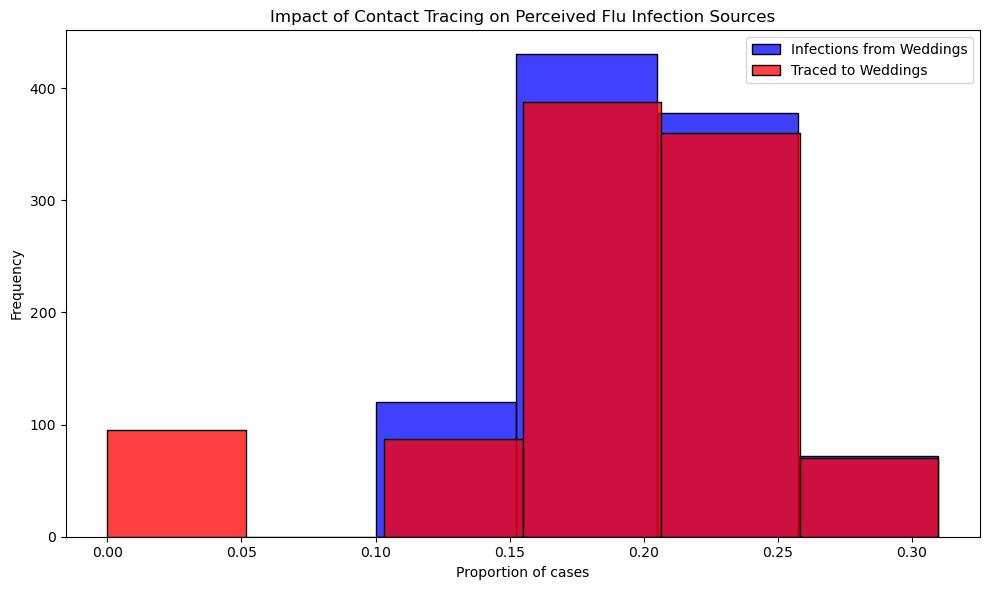

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(1000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

Code repeated four times to check reproducibility with m = 1000.  Plots are below.

   ![Trials with m = 1000](/Users/christineromano/DSI_Course/DSI_Sampling/sampling/02_activities/assignments/assignment_1_1000reps_tiled_graphs.png)

Trial 2: code run with number of repetitions = 10

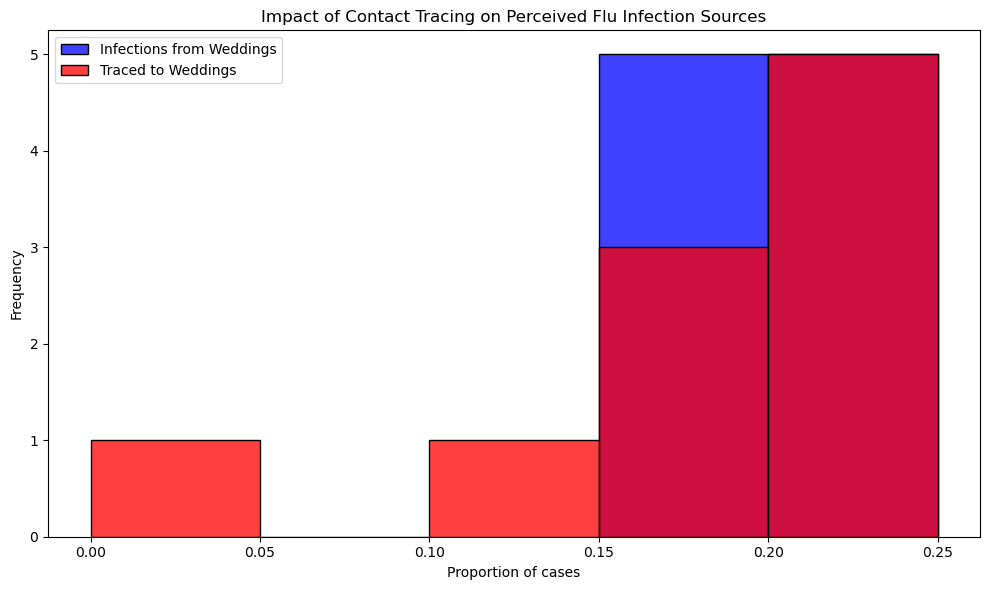

In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 10 times
results = [simulate_event(m) for m in range(10)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

Code repeated four times to check reproducibility with m = 10.   Plots are below.

 ![Trials with m = 100](/Users/christineromano/DSI_Course/DSI_Sampling/sampling/02_activities/assignments/assignment_1_10reps_tiled_graphs.png)

Trial 3: code run with number of repetitions = 100

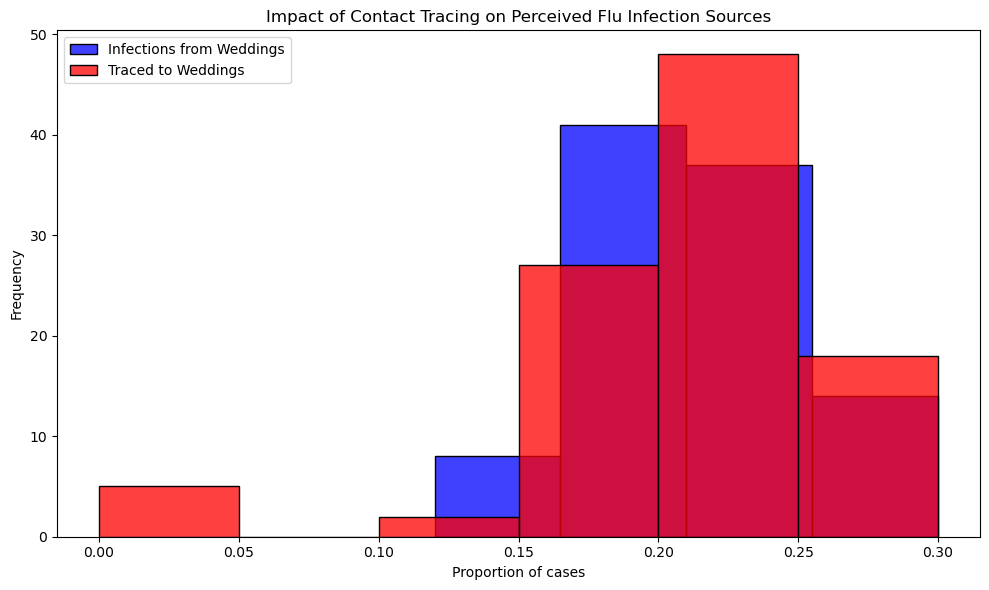

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 100 times
results = [simulate_event(m) for m in range(100)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

Code repeated four times with m = 100 to check reproducibility.  Plots are below.

 ![Trials with m = 100](/Users/christineromano/DSI_Course/DSI_Sampling/sampling/02_activities/assignments/assignment_1_100reps_tiled_graphs.png)

Trial 4: Trying to make the output reproducible.

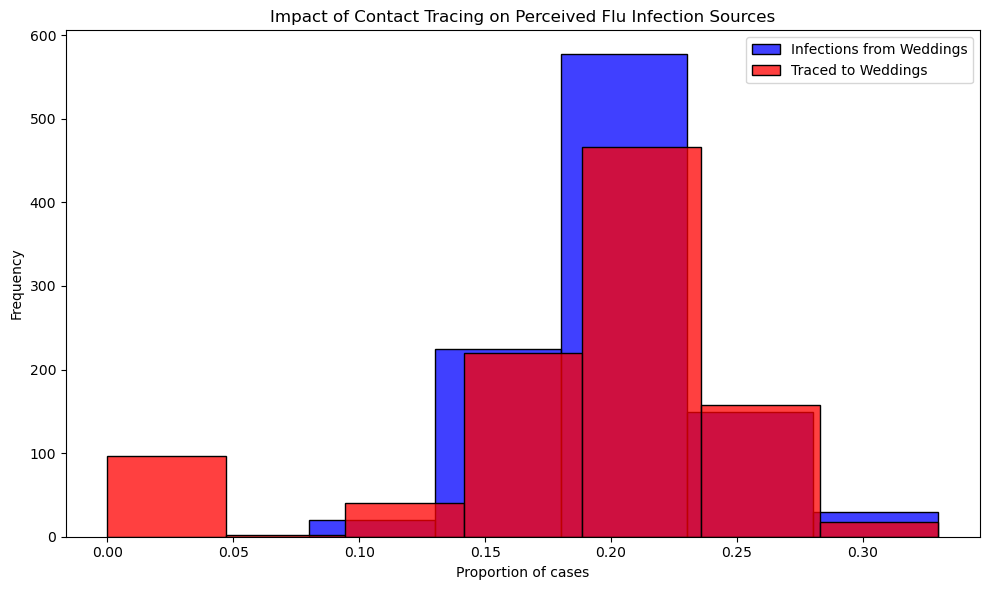

In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2
np.random.seed(42)  # Added to ensure reproducibility

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(1000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

Out of curiosity, I also wanted to prepare a graph that plotted the probabilities for brunches in addition to weddings.  

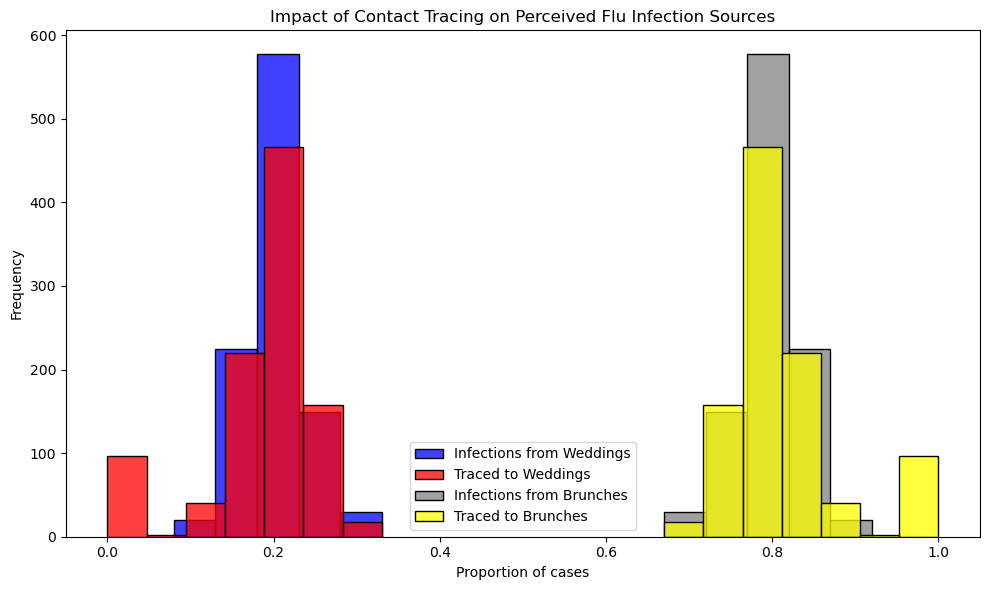

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2
np.random.seed(42)  # Added to ensure reproducibility

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)
  p_brunch_infections = brunch_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)
  p_brunch_traces = brunch_traces / (wedding_traces + brunch_traces)
  
  return p_wedding_infections, p_brunch_infections, p_wedding_traces, p_brunch_traces

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(1000)]
props_df = pd.DataFrame(results, columns=["Infections_W", "Infections_B",  "Traces_W", "Traces_B"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections_W'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces_W'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
sns.histplot(props_df['Infections_B'], color="grey", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Brunches')
sns.histplot(props_df['Traces_B'], color="yellow", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Brunches')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|--------|----|----|
|Alteration of the code|The code changes made, made it reproducible.|The code is still not reproducible.|
|Description of changes|The author answered questions and explained the reasonings for the changes made well.|The author did not answer questions or explain the reasonings for the changes made well.|

## Submission Information
🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 - 22/06/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This markdown file (`a1_sampling_and_reproducibility.ipynb`) should be populated with the code changed.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/sampling/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

#### Checklist:
- [ ] Create a branch called `assignment-1`.
- [ ] Ensure that the repository is public.
- [ ] Review [the PR description guidelines](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md#guidelines-for-pull-request-descriptions) and adhere to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via the help channel in Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
